# **Import Libraries**

In [4]:
import torch
from torch import nn
import pandas as pd
import random
from torch.utils import data
import time
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch.optim.lr_scheduler as lr_scheduler
import json

from IPython.display import set_matplotlib_formats
%matplotlib inline
from IPython import display

# **Functions**

In [5]:
class Animator:  
    """For plotting data in animation.
    #used in training loop
    """
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(7.5, 5.5), set_ylabel=False):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend, set_ylabel)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [6]:
def use_svg_display(): 
    """Use the svg format to display a plot in Jupyter.""" 
    set_matplotlib_formats('svg')

In [7]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend, set_ylabel): 
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale) 
    axes.set_yscale(yscale) 
    axes.set_xlim(xlim) 
    axes.set_ylim(ylim)
    if set_ylabel:
      axes.set_yticks([-1, -0.6, -0.2, 0.2, 0.6, 1])
      axes.set_yticklabels(['None', 'D0', 'D1', 'D2', 'D3', 'D4'])
    if legend: 
        axes.legend(legend)
    axes.grid()

In [8]:
class Accumulator: 
    """For accumulating sums over `n` variables.
    Used in traing loop for accumulating the loss
    """
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
class Timer: 
    """Record multiple running times.    
    """
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [10]:
def get_time_series_inputs(df, col_list, L=4, index_start=0):
  
    df1 = df[col_list].iloc[index_start:index_start + L]
    output = []
    for col in col_list:
        output.append(list(df1[col].values))
    
    return torch.tensor(output, dtype=torch.float32)

In [11]:
def seq_data_iter_random(feature, label, batch_size, num_steps):  
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    start_point = random.randint(0, num_steps - 1)
    feature = feature[start_point:]
    label = label[start_point:]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(feature) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos, longdata):
        # Return a sequence of length `num_steps` starting from `pos`
        return longdata[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j, feature) for j in initial_indices_per_batch]
        Y = [data(j, label) for j in initial_indices_per_batch]
        yield torch.cat(X, dim=0).reshape(len(X), len(X[0]),-1), torch.cat(Y, dim=0).reshape(len(Y), len(Y[0]),-1)

In [12]:
def seq_data_iter_sequential(feature, label, batch_size, num_steps):  
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    # offset = random.randint(0, num_steps)
    offset = 0
    num_tokens = ((len(feature) - offset - 1) // batch_size) * batch_size
    Xs = feature[offset:offset + num_tokens]
    Ys = label[offset:offset + num_tokens]
    
    dimen = Xs.shape[1]
    dimen_Y = Ys.shape[1]
    Xs, Ys = Xs.reshape(batch_size, -1, dimen), Ys.reshape(batch_size, -1, dimen_Y)
    
    num_batches = Xs.shape[1] // num_steps
    # for i in range(0, num_steps * num_batches, num_steps):
    for i in range(0, num_steps * num_batches, 1):
        # print(f"i: {i}")
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [13]:
def batching_data(X):
    """the return shape will be (time_step, batch, features)"""
    Z = []
    for i in range(X.shape[1]):
        Z.append(X[:, i, :])
    return torch.cat(Z, dim=0).reshape(X.shape[1],X.shape[0],-1)

In [14]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}') 
    return torch.device('cpu')

In [15]:
class SeqDataLoader:  
    """An iterator to load sequence data."""
    def __init__(self, my_seq1, my_seq2, batch_size, num_steps, use_random_iter):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        
        self.my_seq1, self.my_seq2 =  my_seq1, my_seq2
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.my_seq1, self.my_seq2, self.batch_size, self.num_steps)

In [16]:
def load_data_time_series(my_seq1, my_seq2, batch_size, num_steps,  
                           use_random_iter=False):
    """Return the iterator"""
    data_iter = SeqDataLoader(my_seq1, my_seq2, batch_size, num_steps, use_random_iter)
    return data_iter

In [17]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [18]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch."""
    state_1, state_2, timer = None, None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of sequences
    
    for X, Y in train_iter:

        if state_1 is None or state_2 is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state_1, state_2 = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y[:, -1, :]
        X, Y = X.to(device), Y.to(device)
        
        # make it as num_step, batch_size*feature
        X, Y = batching_data(X), batching_data(Y)
        y_hat, state = net((X, Y), state_1, state_2)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())

    return metric[0] / metric[1], metric[1]

In [19]:
def train(net, train_iter, test_iter, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model"""    
    loss = nn.MSELoss()
    animator = Animator(xlabel='epoch', ylabel='MSE Loss',
                            legend=['train loss', 'validation loss'], xlim=[10, num_epochs])
    
    
    if isinstance(net, nn.Module):
        updater = torch.optim.Adam(net.parameters(), lr)
        
    else:
        updater = torch.optim.Adam(net.params, lr)
        
    valid_min_error = 1e3      #set the initial validation error to a large value
    for epoch in range(num_epochs):
        train_loss, num_train_sample = train_epoch(net, train_iter, loss, updater, device,
                                     use_random_iter)
        validation_loss, num_valid_sample = evaluate_model(net, test_iter, loss, device, use_random_iter)
        

        #save the params in the case of finding min error every other 50 epoches
        if epoch > 50:
          if validation_loss < valid_min_error:
            valid_min_error = validation_loss
            opt_params = net.params

        if (epoch + 1) % 10 == 0:
            print(f"train loss: {train_loss}, validation loss: {validation_loss}")
            animator.add(epoch + 1, [train_loss, validation_loss])
    return valid_min_error, opt_params

In [20]:
def evaluate_model(net, test_iter, loss, device, use_random_iter):
    """Test the model on test set"""
    state_1, state_2, timer = None, None, Timer()

    if isinstance(net, torch.nn.Module):
      net.eval() # Set the model to evaluation mode

    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    
    with torch.no_grad():
      for X, Y in test_iter:

          if state_1 is None or state_2 is None or use_random_iter:
              # Initialize `state` when either it is the first iteration or
              # using random sampling
              state_1, state_2 = net.begin_state(batch_size=X.shape[0], device=device)
          else:
              if isinstance(net, nn.Module) and not isinstance(state, tuple):
                  # `state` is a tensor for `nn.GRU`
                  state.detach_()
              else:
                  # `state` is a tuple of tensors for `nn.LSTM` and
                  # for our custom scratch implementation
                  for s in state:
                      s.detach_()
          y = Y[:, -1, :] 
          X, Y = X.to(device),  Y.to(device)
          # make it as num_step, batch_size*feature
          X, Y = batching_data(X), batching_data(Y)
          y_hat, state = net((X, Y), state_1, state_2)
          l = loss(y_hat, y)
          metric.add(l * y.numel(), y.numel())

    return metric[0] / metric[1], metric[1]

In [21]:
def test(net, test_iter, device,
              use_random_iter=False):
    """Test a model"""
    loss = nn.MSELoss()
    ppl, acc = evaluate_model(net, test_iter, loss, device, use_random_iter)
    print(f"loss: {ppl}")    

In [22]:
def get_lstm_params(num_exoc, num_hiddens_1, num_hiddens_2, device):
    num_inputs = num_exoc
    num_outputs = 1

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens_1)), normal((num_hiddens_1, num_hiddens_1)),
                torch.zeros(num_hiddens_1, device=device))
    
    def three_2():
        return (normal(
            (num_outputs, num_hiddens_2)), normal((num_hiddens_2, num_hiddens_2)),
                torch.zeros(num_hiddens_2, device=device))
    #first lstm
    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    
    #second lstm
    W_hhi, W_di, b_id = three_2()  # Input gate parameters
    W_hhf, W_df, b_fd = three_2()  # Forget gate parameters
    W_hho, W_do, b_od = three_2()  # Output gate parameters
    W_hhc, W_dc, b_cd = three_2()  # Candidate memory cell parameters
    
    # Output layer parameters
    W_hq = normal((num_hiddens_1 + num_hiddens_2, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    #input attention layer
    U_ex = normal((num_inputs, num_inputs))
    v_e = normal((1, num_inputs))
    W_e = normal((2*num_hiddens_1, num_inputs))
    b_e = torch.zeros(num_outputs, device=device)
    
    #Temporal attention layer
    U_dx = normal((num_hiddens_1, num_hiddens_1))
    v_d = normal((1, num_hiddens_1))
    W_d = normal((2*num_hiddens_2, num_hiddens_1))
    b_d = torch.zeros(num_outputs, device=device)
    
    #for matching with decoder input
    W_hat = normal((num_hiddens_1 + 1, num_outputs))
    b_hat = torch.zeros(num_outputs, device=device)
     
    # Attach gradients
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q,
        U_ex, W_e, b_e, v_e,
        U_dx, W_d, b_d, v_d,
        W_hhi, W_di, b_id, W_hhf, W_df, b_fd, W_hho, W_do, b_od, W_hhc, W_dc, b_cd,
        W_hat, b_hat]
    for param in params:
        param.requires_grad_(True)
    return params

In [23]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [24]:
def lstm(inputs, state_1, state_2, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,W_hq, b_q, U_ex, W_e, b_e, v_e,\
     U_dx, W_d, b_d, v_d, W_hhi, W_di, b_id, W_hhf, W_df, b_fd, W_hho, W_do, b_od, W_hhc, W_dc, b_cd,\
     W_hat, b_hat] = params
    
    (H, C) = state_1
    (D, S) = state_2
    outputs = []

    for i, (X, Y) in enumerate(zip(inputs[0], inputs[1])):    #iterate through time steps


        #input attention output
        E = torch.tanh((X @ U_ex)+(torch.cat((H, C), dim=1) @ W_e) + b_e) * v_e
        m = nn.Softmax(dim=1)
        X = m(E) * X
        
        #Encoder LSTM - iterates through time step
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        
        #Temporal Attn output
        E1 = torch.tanh((H @ U_dx)+(torch.cat((D, S), dim=1) @ W_d) + b_d) * v_d
        H_prime = m(E1) * H
        
        #for matching with input of decoder
        Y_hat = (torch.cat((H_prime, Y), dim=1) @ W_hat) + b_hat
        
        #Decoder LSTM
        I_prime = torch.sigmoid((Y_hat @ W_hhi) + (D @ W_di) + b_id)
        F_prime = torch.sigmoid((Y_hat @ W_hhf) + (D @ W_df) + b_fd)
        O_prime = torch.sigmoid((Y_hat @ W_hho) + (D @ W_do) + b_od)
        S_tilda = torch.tanh((Y_hat @ W_hhc) + (D @ W_dc) + b_cd)
        S = F_prime * S + I_prime * S_tilda
        D = O_prime * torch.tanh(S)


        # only when we are at step T-1
        if i == inputs[0].shape[0] - 2:
            Y_T = (torch.cat((D, H_prime), dim=1) @ W_hq) + b_q
            return Y_T, (H, D)


In [25]:
class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, num_exog, num_hiddens_1, num_hiddens_2, device, get_params,
                 init_state, forward_fn, is_train=True):
        self.num_exog, self.num_hiddens_1, self.num_hiddens_2 = num_exog, num_hiddens_1, num_hiddens_2
        
        if is_train:
          self.params = get_params(num_exog, num_hiddens_1, num_hiddens_2, device)
        else:
          self.params = get_params
        
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state_1, state_2):
        return self.forward_fn(X, state_1, state_2, self.params)

    def begin_state(self, batch_size, device):
        return (self.init_state(batch_size, self.num_hiddens_1, device),
                self.init_state(batch_size, self.num_hiddens_2, device))

In [26]:
def predict(data, net, test_iter, device, warmup=True, use_random_iter=False):
    """Test the model on test set"""
    state_1, state_2, timer = None, None, Timer()

    animator = Animator(xlabel='time index', ylabel='Drought Level',
                            legend=['True Value', 'Predicted Value'], figsize=(9.5, 7.5), set_ylabel=True)

    if isinstance(net, torch.nn.Module):
      net.eval() # Set the model to evaluation mode

    

    if state_1 is None or state_2 is None or use_random_iter:
      # Initialize `state` when either it is the first iteration or
      # using random sampling
      state_1, state_2 = net.begin_state(batch_size=1, device=device)
    else:
      if isinstance(net, nn.Module) and not isinstance(state, tuple):
        # `state` is a tensor for `nn.GRU`
        state.detach_()
      else:
        # `state` is a tuple of tensors for `nn.LSTM` and
        # for our custom scratch implementation
        for s in state:
          s.detach_()

    idx = 0
    with torch.no_grad():
      for X, Y in test_iter:
          
          
          y = Y[:, -1, :] 
          X, Y = X.to(device),  Y.to(device)
          # make it as num_step, batch_size*feature
          X, Y = batching_data(X), batching_data(Y)
          y_hat, state = net((X, Y), state_1, state_2)

          animator.add(idx, [y, level_conv(y_hat[0][0].item(), beta_0=-0.8, beta_1=-0.4, beta_2=0, beta_3=0.4, beta_4=optim_thr)])
          idx += 1
          
    
    return y_hat

In [27]:
def threshold_set(L_3_4, L_4_3, p_d_3=0.054, p_d_4=0.021, sigma=0.1):
  """
  used in risk management

  -L_3_4: the loss if we mix D3 with D4
  -L_4_3: the loss if we mix D4 with D3
  -p_d_3: the frequency of drought level D3
  -p_d_4: the frequency of drought level D4
  """
  T_l = np.log(L_3_4/L_4_3)
  T_p = np.log(p_d_3/p_d_4)
  return 0.8 - 2.5 * (sigma ** 2) * (T_l - T_p)

In [28]:
def level_conv(x, beta_0=-0.8, beta_1=-0.4, beta_2=0, beta_3=0.4, beta_4=0.8):
  """
  used to convert the continuous value of regression into drought level
  """
  if x < beta_0:
    return -1
  elif x >= beta_0 and x < beta_1:
    return -0.6
  elif x >= beta_1 and x < beta_2:
    return -0.2
  elif x >= beta_2 and x < beta_3:
    return 0.2
  elif x >= beta_3 and x < beta_4:
    return 0.6
  else:
    return 1

# **Load and Wrangle Data**

In [29]:
training_set = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/traning_2.pkl")
training_set

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,date,fips,class
0,1.77,99.65,8.12,14.82,10.34,10.35,21.28,8.17,13.11,14.89,1.84,2.67,0.89,1.78,3.64,5.34,1.90,3.45,2000-06-27,1001,D2
1,7.52,99.52,11.90,19.60,16.55,16.54,26.70,13.35,13.35,19.65,2.18,3.20,1.02,2.18,4.31,6.42,1.64,4.78,2000-06-28,1001,D2
2,0.14,100.14,8.85,17.07,12.09,12.09,25.05,9.47,15.58,17.03,1.70,2.10,1.15,0.96,3.40,4.96,2.05,2.90,2000-06-29,1001,D2
3,8.03,100.30,10.74,18.53,15.10,15.10,24.96,12.94,12.02,18.55,2.75,4.15,1.93,2.22,5.57,6.59,3.98,2.61,2000-06-30,1001,D2
4,35.46,100.10,13.72,19.75,18.85,18.85,23.77,16.35,7.42,19.74,2.47,3.13,1.68,1.45,5.07,6.75,3.60,3.15,2000-07-01,1001,D2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.00,84.43,2.86,-1.58,-6.02,-5.97,1.82,-4.50,6.32,-2.82,1.77,2.81,0.81,2.00,2.74,4.82,0.98,3.84,2009-03-11,16031,D1
86,1.02,82.89,3.32,-0.02,-4.30,-4.28,4.35,-3.69,8.04,-0.62,3.15,4.92,1.24,3.67,4.88,8.10,1.89,6.21,2009-03-12,16031,D1
87,2.69,81.83,2.31,-5.09,-9.21,-9.10,-0.46,-8.72,8.26,-5.06,6.79,9.38,2.79,6.59,8.71,11.78,4.14,7.64,2009-03-13,16031,D1
88,0.83,82.60,1.85,-7.05,-11.23,-11.10,-4.64,-9.72,5.08,-7.18,2.97,4.74,0.99,3.74,3.96,5.73,1.84,3.90,2009-03-14,16031,D1


In [31]:
# training_set['fips'].unique()

In [65]:
validation_set = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/validation_dataframe_pandas.pkl")
validation_set

PRECTOT      PS  QV2M  ...  WS50M_MIN  WS50M_RANGE  class
fips  date                               ...                               
1001  2010-05-04     0.00  100.67  4.83  ...       1.95         3.69   None
      2010-05-05    40.20  100.30  6.01  ...       2.63         7.72   None
      2010-05-06    29.92   99.04  7.33  ...       1.71         8.13   None
      2010-05-07     0.55   99.65  4.41  ...       4.80         3.11   None
      2010-05-08     0.00  100.30  3.46  ...       1.69         2.85   None
...                   ...     ...   ...  ...        ...          ...    ...
56043 2012-02-22     0.77   82.54  3.42  ...       6.44         3.01   None
      2012-02-23     0.58   82.69  2.82  ...       5.31         6.90   None
      2012-02-24     0.00   84.27  1.63  ...       1.66         7.12   None
      2012-02-25     1.05   83.81  2.61  ...       3.87         5.17   None
      2012-02-26     0.05   83.68  3.37  ...       0.93         6.78   None

[1864890 rows x 19 columns]

In [66]:
test_data=a = validation_set.loc[[1001, 1005, 56043]]
test_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/test_dataframe.pkl")

In [34]:
training_set['fips'].unique()
data_valid = validation_set.loc[(56043)]

In [ ]:
#proportion of class in each data frame
training_set['class'].value_counts()/len(training_set)

None    0.550122
D0      0.166542
D1      0.116194
D2      0.090545
D3      0.054647
D4      0.021949
Name: class, dtype: float64

In [35]:
#encode the ordinal factor variabels/targets
cleanup_nums = {"class":     {"None": -1, "D0": -0.6, "D1": -0.2,"D2": 0.2, "D3": 0.6, "D4": 1}}
training_set.replace(cleanup_nums, inplace=True)
training_set.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,date,fips,class
0,1.77,99.65,8.12,14.82,10.34,10.35,21.28,8.17,13.11,14.89,1.84,2.67,0.89,1.78,3.64,5.34,1.90,3.45,2000-06-27,1001,0.2
1,7.52,99.52,11.90,19.60,16.55,16.54,26.70,13.35,13.35,19.65,2.18,3.20,1.02,2.18,4.31,6.42,1.64,4.78,2000-06-28,1001,0.2
2,0.14,100.14,8.85,17.07,12.09,12.09,25.05,9.47,15.58,17.03,1.70,2.10,1.15,0.96,3.40,4.96,2.05,2.90,2000-06-29,1001,0.2
3,8.03,100.30,10.74,18.53,15.10,15.10,24.96,12.94,12.02,18.55,2.75,4.15,1.93,2.22,5.57,6.59,3.98,2.61,2000-06-30,1001,0.2
4,35.46,100.10,13.72,19.75,18.85,18.85,23.77,16.35,7.42,19.74,2.47,3.13,1.68,1.45,5.07,6.75,3.60,3.15,2000-07-01,1001,0.2


In [36]:
#encode the ordinal factor variabels/targets
cleanup_nums = {"class":     {"None": -1, "D0": -0.6, "D1": -0.2,"D2": 0.2, "D3": 0.6, "D4": 1}}
validation_set.replace(cleanup_nums, inplace=True)
validation_set.head()

PRECTOT      PS  QV2M  ...  WS50M_MIN  WS50M_RANGE  class
fips date                               ...                               
1001 2010-05-04     0.00  100.67  4.83  ...       1.95         3.69   -1.0
     2010-05-05    40.20  100.30  6.01  ...       2.63         7.72   -1.0
     2010-05-06    29.92   99.04  7.33  ...       1.71         8.13   -1.0
     2010-05-07     0.55   99.65  4.41  ...       4.80         3.11   -1.0
     2010-05-08     0.00  100.30  3.46  ...       1.69         2.85   -1.0

[5 rows x 19 columns]

In [37]:
#remove the indices
training_set = pd.DataFrame(training_set.values, columns=training_set.columns)
validation_set = pd.DataFrame(validation_set.values, columns=validation_set.columns)
len(training_set), len(validation_set)

(1800090, 1864890)

In [38]:
##### Run this block if you want to include the moment (first derivative) and force (second derivative) of the indicators #######
#add momentum and force to the data
feature_list = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']

diff_col = {}
sec_diff_col = {}
for col in feature_list:
  diff_col[col] = col+'_d'
  sec_diff_col[col] = col+'_dd'

x = training_set
y = x[feature_list].diff(periods=1)
y.rename(columns = diff_col, inplace = True)
z = x[feature_list].diff(periods=1).diff(periods=1)
z.rename(columns = sec_diff_col, inplace = True)
training_set = pd.concat([z, y, x], axis=1)

x = validation_set
y = x[feature_list].diff(periods=1)
y.rename(columns = diff_col, inplace = True)
z = x[feature_list].diff(periods=1).diff(periods=1)
z.rename(columns = sec_diff_col, inplace = True)
validation_set = pd.concat([z, y, x], axis=1)

In [39]:
# run this block if the memory is not enough to accommodate whole data
training_set = training_set[2:60000]
validation_set = validation_set[2:20000]

In [40]:
#normalise the inputs
feature_list = ['PRECTOT_dd', 'PS_dd', 'QV2M_dd', 'T2M_dd', 'T2MDEW_dd', 'T2MWET_dd',
       'T2M_MAX_dd', 'T2M_MIN_dd', 'T2M_RANGE_dd', 'TS_dd', 'WS10M_dd',
       'WS10M_MAX_dd', 'WS10M_MIN_dd', 'WS10M_RANGE_dd', 'WS50M_dd',
       'WS50M_MAX_dd', 'WS50M_MIN_dd', 'WS50M_RANGE_dd', 'PRECTOT_d', 'PS_d',
       'QV2M_d', 'T2M_d', 'T2MDEW_d', 'T2MWET_d', 'T2M_MAX_d', 'T2M_MIN_d',
       'T2M_RANGE_d', 'TS_d', 'WS10M_d', 'WS10M_MAX_d', 'WS10M_MIN_d',
       'WS10M_RANGE_d', 'WS50M_d', 'WS50M_MAX_d', 'WS50M_MIN_d',
       'WS50M_RANGE_d', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE']
 
scaler = preprocessing.StandardScaler() 

validation_set[feature_list] = scaler.fit_transform(validation_set[feature_list])
training_set[feature_list] = scaler.fit_transform(training_set[feature_list])

In [58]:
#set the netwrok hyperparameters
num_epochs = 500
batch_size = 128
num_steps = 3
num_hiddens_1 = 256
num_hiddens_2 = 256
lr = 0.001

#uncomment this if you want to exclude the moment and force of indicators
feature_list = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']

label_list = ['class']
num_exoc = len(feature_list)

long_df_2 = training_set
long_df_1 = validation_set

my_seq1, my_seq2 = get_time_series_inputs(long_df_2, feature_list, L=len(long_df_2), index_start=0), get_time_series_inputs(long_df_2, label_list, L=len(long_df_2), index_start=0)
my_seq1 = my_seq1.T
my_seq2 = my_seq2.T
device = try_gpu()
my_seq1_valid, my_seq2_valid = get_time_series_inputs(long_df_1, feature_list, L=len(long_df_1), index_start=0), get_time_series_inputs(long_df_1, label_list, L=len(long_df_1), index_start=0)
my_seq1_valid = my_seq1_valid.T
my_seq2_valid = my_seq2_valid.T


The minimum validation loss is 0.007


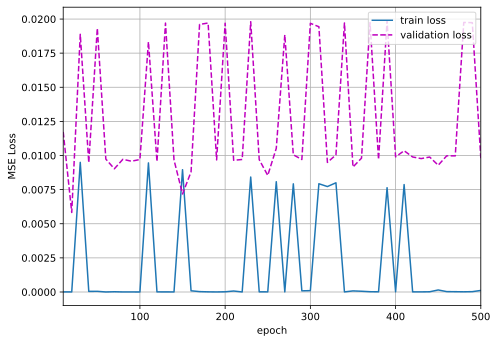

In [59]:
print(f"num hiddens 1: {num_hiddens_1}, num hiddens 2: {num_hiddens_2}")
net = RNNModelScratch(num_exoc, num_hiddens_1, num_hiddens_2, try_gpu(), get_lstm_params, init_lstm_state, lstm)
train_iter = load_data_time_series(my_seq1, my_seq2, batch_size, num_steps, use_random_iter=True)

test_iter = load_data_time_series(my_seq1_valid, my_seq2_valid, batch_size, num_steps, use_random_iter=True)
valid_min_loss, opt_params = train(net, train_iter, test_iter, lr, num_epochs, device, use_random_iter=True)

print("The minimum validation loss is {:.3f}".format(valid_min_loss))

In [60]:
# saving the model
torch.save(opt_params, f'/content/drive/MyDrive/Colab Notebooks/DARNN_{num_steps}_{num_hiddens_1}_{lr}_{batch_size}_lms.params')

In [61]:
#loading the model
print(f"{num_steps}_{num_hiddens_1}_{lr}_{batch_size}")
params = torch.load(f'/content/drive/MyDrive/Colab Notebooks/DARNN_{num_steps}_{num_hiddens_1}_{lr}_{batch_size}_lms.params') 
net = RNNModelScratch(num_exoc, num_hiddens_1, num_hiddens_2, try_gpu(), params, init_lstm_state, lstm, False) 
len(params)

3_256_0.001_128


36

In [53]:
data_valid = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/validation_dataframe.pkl")
data_valid

PRECTOT      PS  QV2M  ...  WS50M_MIN  WS50M_RANGE  class
fips  date                               ...                               
1001  2010-05-04     0.00  100.67  4.83  ...       1.95         3.69   None
      2010-05-05    40.20  100.30  6.01  ...       2.63         7.72   None
      2010-05-06    29.92   99.04  7.33  ...       1.71         8.13   None
      2010-05-07     0.55   99.65  4.41  ...       4.80         3.11   None
      2010-05-08     0.00  100.30  3.46  ...       1.69         2.85   None
...                   ...     ...   ...  ...        ...          ...    ...
56043 2012-02-22     0.77   82.54  3.42  ...       6.44         3.01   None
      2012-02-23     0.58   82.69  2.82  ...       5.31         6.90   None
      2012-02-24     0.00   84.27  1.63  ...       1.66         7.12   None
      2012-02-25     1.05   83.81  2.61  ...       3.87         5.17   None
      2012-02-26     0.05   83.68  3.37  ...       0.93         6.78   None

[1440 rows x 19 columns]

In [54]:
data_valid = data_valid.loc[(1005)]

cleanup_nums = {"class":     {"None": -1, "D0": -0.6, "D1": -0.2,"D2": 0.2, "D3": 0.6, "D4": 1}}
data_valid.replace(cleanup_nums, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
training_set['fips'].unique()

array([1001, 1005, 1003, 1007, 1009, 1011, 1013, 1015, 1017, 1019, 1021,
       1023, 1025, 1027, 1029, 1031, 1033, 1035], dtype=object)

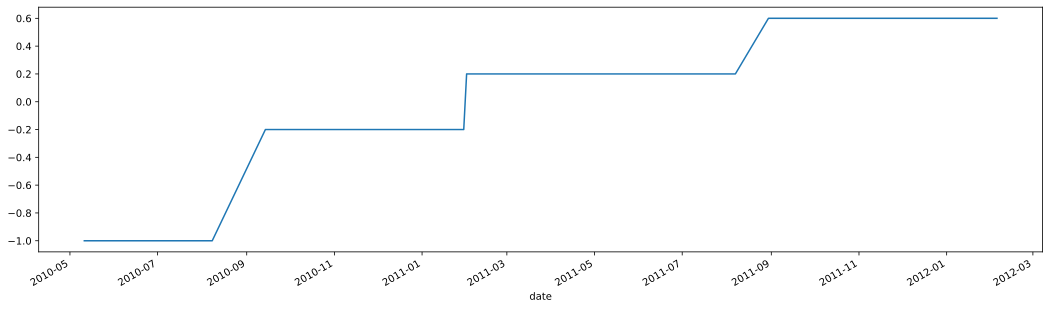

In [55]:
data_valid['class'].plot(figsize=(18,5))

In [62]:
my_seq1, my_seq2 = get_time_series_inputs(data_valid, feature_list, L=len(data_valid), index_start=0), get_time_series_inputs(data_valid, label_list, L=len(data_valid), index_start=0)
my_seq1 = my_seq1.T
my_seq2 = my_seq2.T
device = try_gpu()
batch_size=1
test_iter = load_data_time_series(my_seq1, my_seq2, batch_size, num_steps,  
                           use_random_iter=False)

# **Drough Risk Management**

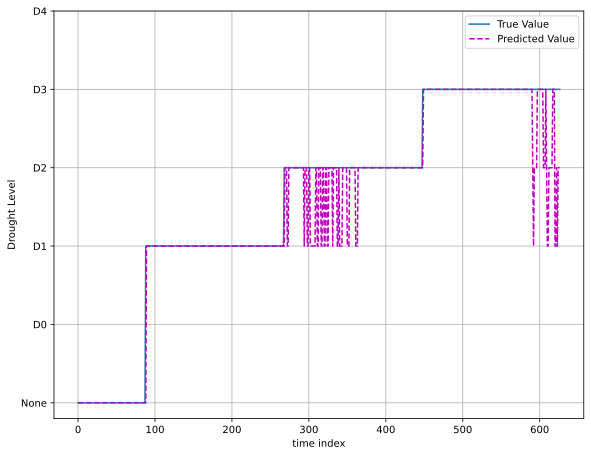

In [63]:
# the loss value in dollar$
L_3_4=6
L_4_3=1

optim_thr = threshold_set(L_3_4, L_4_3, p_d_3=0.054, p_d_4=0.021, sigma=0.1)
print(f"optimum threshold for the given risk is {optim_thr}")

y_hat = predict(data_valid, net, test_iter, device)